# Metrics

This document contains the code in order to elaborate the data about the following metrics: system load, memory usage, throughput and CPU usage from ELIot containes. 

Each metrics takes in input the data of three different runs (it is possible adding more runs changing the value of RUN_NUMBER). The data can be taken from Grafana. 

In [1]:
%matplotlib inline

import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
TEST_NUMBER = 6
RUN_NUMBER = 3

#Retrieve the start and the end time for each test
def retrieve_test_times(index, test_times):
    start_time = []
    end_time = []

    for test in test_times:
        time = test.split(",")
        date = time[0] + " " + time[1]
        if " Starting scaling Test " + str(index) in test:
            start_time.append(date)
        elif "Test " + str(index) + " stabilization period elapsed" in test:
            end_time.append(date)
    return start_time, end_time


#Retrieve total seconds
def retrieve_total_seconds(start_time, end_time):
    start_datetime =pd.to_datetime(start_time, format='%Y-%m-%d %H:%M:%S')
    end_datetime = pd.to_datetime(end_time, format='%Y-%m-%d %H:%M:%S')
    delta_time = end_datetime - start_datetime
    seconds = delta_time.total_seconds()
    return seconds

#Get the minimum duration and scale the values to that duration
def fix_duration(values, times):
    min = 1000
    for time in times:
        if time < min:
            min = time
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
    return min, new_values

def compute_mean(values, length):
    mean = []
    for i in range(length):
        total = 0
        for j in range(RUN_NUMBER):
            total += values[j][i]
        mean_value = total/RUN_NUMBER
        mean.append(mean_value)
    return mean

def retrieve_start_and_end_time(test_times):
    test_time = {}
    start_time = []
    end_time = []

    for index in range(TEST_NUMBER):
        start_time, end_time = retrieve_test_times(index + 1, test_times)
        test_time["Start_0" + str(index + 1)] = start_time
        test_time["End_0" + str(index + 1)] = end_time
    return test_time

def retrieve_test_values(df01, df02, df03, test_time):
    df = 0
    dict_test_values = {}

    for i in range(TEST_NUMBER):
        dict_test_values["Test_" + str(i + 1) + "_values"] = []
        dict_test_values["Test_" + str(i + 1) + "_time"] = []
        for j in range(RUN_NUMBER):
            if j == 0:
                df = df01
            elif j == 1:
                df = df02
            else:
                df = df03

            test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
            test_values = []
            test_seconds = []

            for time in df["Time"]:
                index = df[df['Time']==time].index.values.astype(int)[0]
                time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
                if time in test_interval:
                    test_values.append(df["Value"][index])

            total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])

            dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
            dict_test_values["Test_" + str(i + 1) + "_time"].append(total_seconds)
    return dict_test_values

#Get the minimum duration and scale the values to that duration
def fix_duration_with_time(values, times):
    min = 1000
    for value in values:
        if len(value) < min:
            min = len(value)
    
    new_values = []
    for value in values:
        new_value = []
        for index in range(int(min)):
            new_value.append(value[index])
        new_values.append(new_value)
        
    new_times = []
    for time in times:
        new_time = []
        for index in range(int(min)):
            new_time.append(time[index])
        new_times.append(new_time)
    return new_times, new_values

def from_s_to_ms(values):
    new_values = []
    for value in values:
        new_values.append(value*1000)
    return new_values

def compute_mean_remove_outliers(values, length):
    mean = []
    for i in range(length):
        total = 0
        count = 0
        for j in range(RUN_NUMBER):
            if values[j][i] < 30000:
                total += values[j][i]
                count += 1
        mean_value = 0 if count == 0 else total/count
        mean.append(mean_value)
    return mean

## System Load of a single test

In [3]:
df_sl01 = pd.read_csv("data/system-load/system_load01.csv")
print(df_sl01)
df_sl02 = pd.read_csv("data/system-load/system_load02.csv")
print(df_sl02)
df_sl03 = pd.read_csv("data/system-load/system_load03.csv")
print(df_sl03)


test_times_file = open("data/system-load/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time      Value
0     2020-08-29 15:56:17   3.800000
1     2020-08-29 15:56:18   3.800000
2     2020-08-29 15:56:19   3.800000
3     2020-08-29 15:56:20   3.790000
4     2020-08-29 15:56:21   3.740000
...                   ...        ...
3827  2020-08-29 17:00:04  27.610000
3828  2020-08-29 17:00:05  27.610000
3829  2020-08-29 17:00:06  27.610000
3830  2020-08-29 17:00:07  27.610000
3831  2020-08-29 17:00:08  27.668333

[3832 rows x 2 columns]
                     Time      Value
0     2020-08-29 17:46:47   3.060000
1     2020-08-29 17:46:48   3.060000
2     2020-08-29 17:46:49   3.060000
3     2020-08-29 17:46:50   3.003333
4     2020-08-29 17:46:51   2.890000
...                   ...        ...
3745  2020-08-29 18:49:12  32.670000
3746  2020-08-29 18:49:13  32.330000
3747  2020-08-29 18:49:14  31.650000
3748  2020-08-29 18:49:15  31.650000
3749  2020-08-29 18:49:16  31.650000

[3750 rows x 2 columns]
                     Time      Value
0     2020-08-29 19:21:03

In [4]:
test_time = retrieve_start_and_end_time(test_times)
dict_test_values = retrieve_test_values(df_sl01, df_sl02, df_sl03, test_time)

In [5]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

In [6]:
for index_test in range(TEST_NUMBER):
    length = int(dict_test_values["Test_" + str(index_test + 1) + "_time"])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"] = compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

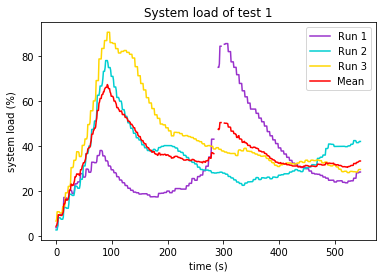

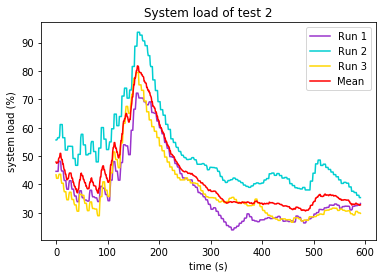

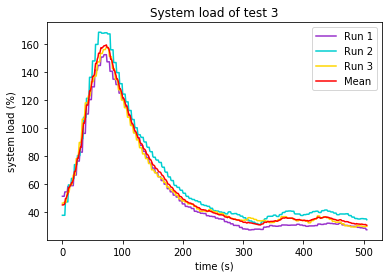

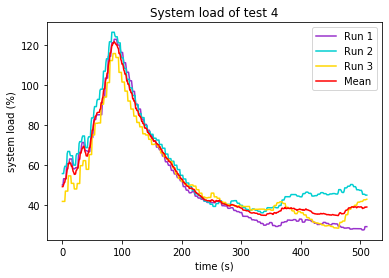

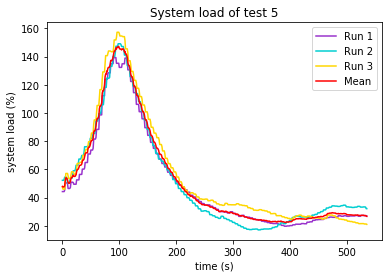

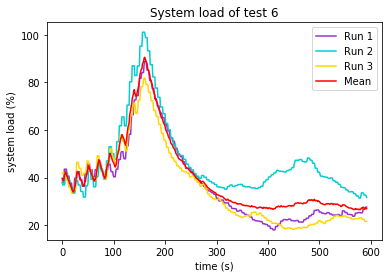

In [7]:
for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('System load of test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('system load (%)')
    leg = ax.legend();
    plt.show()

## System Load of all tests

In [8]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

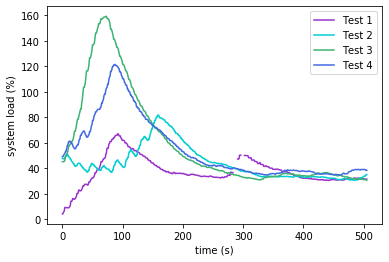

In [9]:
fig, ax = plt.subplots()
        
for index in range(TEST_NUMBER - 2):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('System load of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('system load (%)')
plt.savefig("system_load_ELIot_tests.png")

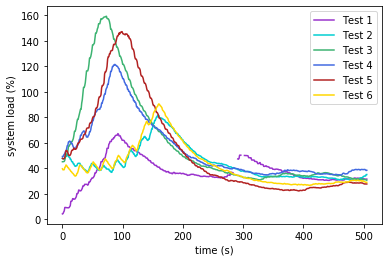

In [10]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('System load of all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('system load (%)')
plt.savefig("system_load_all_tests.png")

# Memory of single test

In [11]:
df_m01 = pd.read_csv("data/memory/memory01.csv")
print(df_m01)
df_m02 = pd.read_csv("data/memory/memory02.csv")
print(df_m02)
df_m03 = pd.read_csv("data/memory/memory03.csv")
print(df_m03)


test_times_file = open("data/memory/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time      Value
0     2020-08-29 15:56:16  16.278610
1     2020-08-29 15:56:18  16.289853
2     2020-08-29 15:56:20  16.285515
3     2020-08-29 15:56:22  16.281315
4     2020-08-29 15:56:24  16.280458
...                   ...        ...
1912  2020-08-29 17:00:00  61.251424
1913  2020-08-29 17:00:02  61.265179
1914  2020-08-29 17:00:04  61.250388
1915  2020-08-29 17:00:06  61.246863
1916  2020-08-29 17:00:08  61.249092

[1917 rows x 2 columns]
                     Time      Value
0     2020-08-29 17:46:46  27.140947
1     2020-08-29 17:46:48  27.144506
2     2020-08-29 17:46:50  27.140230
3     2020-08-29 17:46:52  27.139762
4     2020-08-29 17:46:54  27.148901
...                   ...        ...
1871  2020-08-29 18:49:08  68.430112
1872  2020-08-29 18:49:10  68.430237
1873  2020-08-29 18:49:12  68.434394
1874  2020-08-29 18:49:14  68.436086
1875  2020-08-29 18:49:16  68.438662

[1876 rows x 2 columns]
                     Time      Value
0     2020-08-29 19:21:02

In [12]:
test_time = retrieve_start_and_end_time(test_times)

In [13]:
df = 0
dict_test_values = {}

for i in range(TEST_NUMBER):
    dict_test_values["Test_" + str(i + 1) + "_values"] = []
    dict_test_values["Test_" + str(i + 1) + "_time"] = []
    for j in range(RUN_NUMBER):
        if j == 0:
            df = df_m01
        elif j == 1:
            df = df_m02
        else:
            df = df_m03

        test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
        test_values = []
        test_seconds = []

        for time in df["Time"]:
            index = df[df['Time']==time].index.values.astype(int)[0]
            time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
            if time in test_interval:
                test_values.append(df["Value"][index])
                end_datetime = pd.to_datetime(test_time["End_0" + str(i + 1)][j], format='%Y-%m-%d %H:%M:%S')
                delta_time = end_datetime - time
                seconds = delta_time.total_seconds()
                test_seconds.append(seconds)

        total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])

        seconds = []
        for second in test_seconds:
            sec = total_seconds - second
            seconds.append(sec)
                                   
        dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
        dict_test_values["Test_" + str(i + 1) + "_time"].append(seconds)

In [14]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration_with_time(values, times)

In [15]:
for index_test in range(TEST_NUMBER):
    length = len(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"]= compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

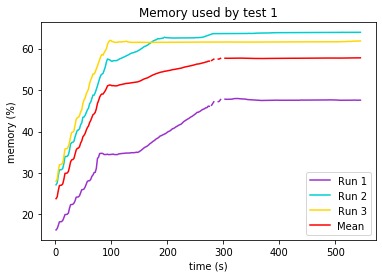

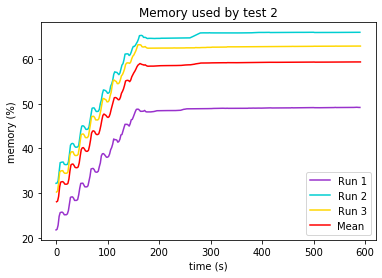

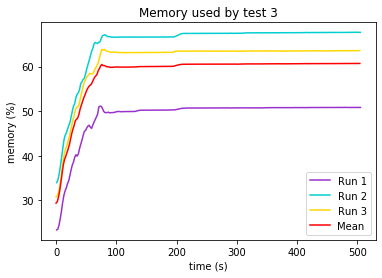

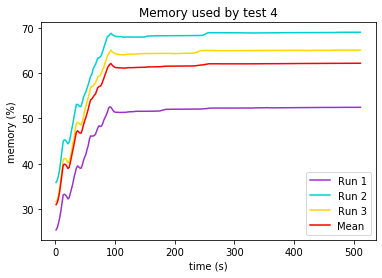

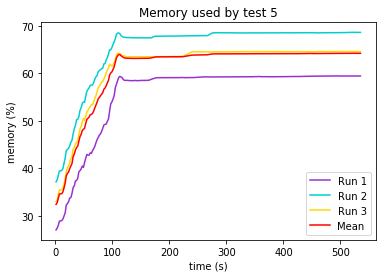

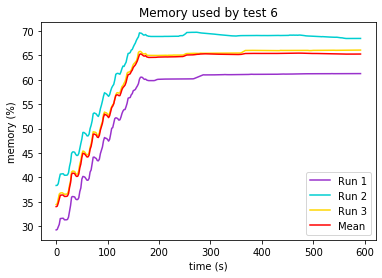

In [16]:
for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('Memory used by test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('memory (%)')
    leg = ax.legend();
    plt.show()

# Memory all

In [17]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])

dict_test["times"], dict_test["values"] = fix_duration_with_time(dict_test["values"], dict_test["times"])

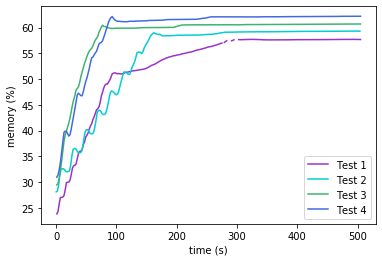

In [18]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER - 2):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Memory used in ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('memory (%)')
plt.savefig("memory_ELIot_tests.png")

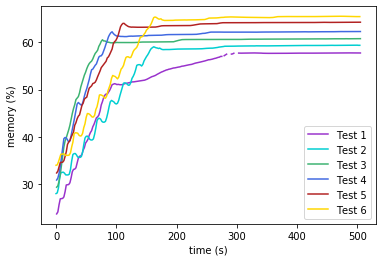

In [19]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Memory used in all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('memory (%)')
plt.savefig("memory_all_tests.png")

# Memory function container

In [30]:
NUMBER_SAVE_TESTS = 4
NUMBER_TESTS = 6

df_m01 = pd.read_csv("data/memory/memory01.csv")
print(df_m01)
df_m02 = pd.read_csv("data/memory/memory02.csv")
print(df_m02)
df_m03 = pd.read_csv("data/memory/memory03.csv")
print(df_m03)

df_c01 = pd.read_csv("data/memory/eliot_container01.csv")
print(df_c01)
df_c02 = pd.read_csv("data/memory/eliot_container02.csv")
print(df_c02)
df_c03 = pd.read_csv("data/memory/eliot_container03.csv")
print(df_c03)

test_times_file = open("data/memory/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time      Value
0     2020-08-25 15:04:06  58.324980
1     2020-08-25 15:04:08  58.649390
2     2020-08-25 15:04:10  59.918528
3     2020-08-25 15:04:12  60.759439
4     2020-08-25 15:04:14  61.681825
...                   ...        ...
1624  2020-08-25 15:58:14  87.419931
1625  2020-08-25 15:58:16  87.569021
1626  2020-08-25 15:58:18  87.510335
1627  2020-08-25 15:58:20  87.443111
1628  2020-08-25 15:58:22  87.565744

[1629 rows x 2 columns]
                     Time      Value
0     2020-08-27 08:30:32  67.827861
1     2020-08-27 08:30:34  68.678029
2     2020-08-27 08:30:36  69.548582
3     2020-08-27 08:30:38  71.028863
4     2020-08-27 08:30:40  71.118570
...                   ...        ...
1588  2020-08-27 09:23:28  75.738816
1589  2020-08-27 09:23:30  75.758954
1590  2020-08-27 09:23:32  75.543309
1591  2020-08-27 09:23:34  75.539704
1592  2020-08-27 09:23:36  75.541044

[1593 rows x 2 columns]
                     Time      Value
0     2020-08-27 12:27:54

In [34]:
test_time = retrieve_start_and_end_time(test_times)

In [35]:
test_time

{'Start_01': ['2020-08-25 15:04:06',
  '2020-08-27 08:30:31',
  '2020-08-27 12:27:53'],
 'End_01': ['2020-08-25 15:12:49',
  '2020-08-27 08:39:04',
  '2020-08-27 12:37:34'],
 'Start_02': ['2020-08-25 15:13:27',
  '2020-08-27 08:39:38',
  '2020-08-27 12:38:07'],
 'End_02': ['2020-08-25 15:22:09',
  '2020-08-27 08:47:54',
  '2020-08-27 12:46:10'],
 'Start_03': ['2020-08-25 15:22:56',
  '2020-08-27 08:48:26',
  '2020-08-27 12:46:42'],
 'End_03': ['2020-08-25 15:31:29',
  '2020-08-27 08:56:46',
  '2020-08-27 12:54:47'],
 'Start_04': ['2020-08-25 15:32:26',
  '2020-08-27 08:57:19',
  '2020-08-27 12:55:20'],
 'End_04': ['2020-08-25 15:40:33',
  '2020-08-27 09:05:37',
  '2020-08-27 13:03:24'],
 'Start_05': ['2020-08-25 15:41:08',
  '2020-08-27 09:06:12',
  '2020-08-27 13:03:56'],
 'End_05': ['2020-08-25 15:49:18',
  '2020-08-27 09:14:20',
  '2020-08-27 13:11:50'],
 'Start_06': ['2020-08-25 15:49:52',
  '2020-08-27 09:14:52',
  '2020-08-27 13:12:22'],
 'End_06': ['2020-08-25 15:58:22',
  '2020

In [36]:
def get_memory_cont(df_m, df_c, num_r):
    new_val = []
    for i, row in df_m.iterrows():
        time = row['Time']
        mem = str(row['Value'])
        c_row = df_c.iloc[ i*2 , : ]
        cont = str(c_row['Value'])
        if mem != 'nan' and cont != 'nan':
            new_val.append([time, float(mem), float(cont)])
    save = []
    for index in range(len(new_val)):
        line = new_val[index]
        if index+1 < len(new_val):
            if line[2] != new_val[index+1][2]:
                save.append(line)
    all_tests = []
    for j in range(NUMBER_TESTS):
        single_test = []
        interval = pd.Interval(pd.Timestamp(test_time['Start_0'+str(j+1)][num_r]),pd.Timestamp(test_time['End_0'+str(j+1)][num_r]))
        for line in save:
            if pd.Timestamp(line[0]) in interval:
                single_test.append(line)
        all_tests.append(single_test)
    return all_tests

In [37]:
all_run = []
all_run.append(get_memory_cont(df_m01, df_c01, 0))
all_run.append(get_memory_cont(df_m02, df_c02, 1))
all_run.append(get_memory_cont(df_m03, df_c03, 2))

In [38]:
all_run

[[[['2020-08-25 15:04:10', 59.918528287930094, 33.0],
   ['2020-08-25 15:04:22', 64.00868202720177, 52.0],
   ['2020-08-25 15:04:24', 64.51380102067388, 62.0],
   ['2020-08-25 15:04:28', 65.38359094874856, 93.0]],
  [['2020-08-25 15:13:28', 64.10552485575836, 4.0],
   ['2020-08-25 15:13:30', 64.54335450106534, 17.0],
   ['2020-08-25 15:13:52', 71.05417636558158, 52.0],
   ['2020-08-25 15:13:56', 72.21498334175709, 83.0]],
  [['2020-08-25 15:22:58', 63.07893532078214, 2.0],
   ['2020-08-25 15:23:00', 63.97766203284627, 33.0],
   ['2020-08-25 15:23:06', 65.10265515081204, 42.0]],
  [['2020-08-25 15:32:30', 68.50068869942696, 17.0],
   ['2020-08-25 15:32:32', 69.6199108286763, 45.0],
   ['2020-08-25 15:32:34', 70.76270051519778, 57.0]],
  [['2020-08-25 15:41:10', 69.45758162092613, 29.0],
   ['2020-08-25 15:41:12', 70.06728438814045, 50.0],
   ['2020-08-25 15:41:22', 72.43357162945244, 52.0],
   ['2020-08-25 15:41:24', 72.9331651554298, 51.0],
   ['2020-08-25 15:41:28', 75.32853136810542,

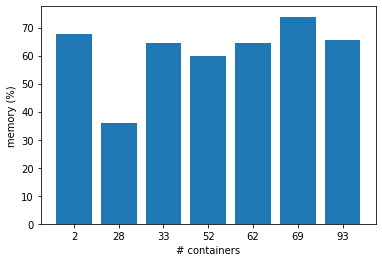

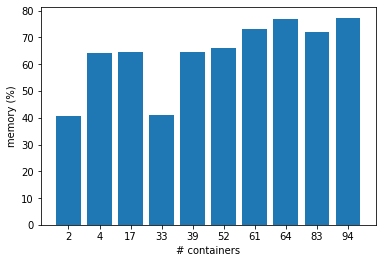

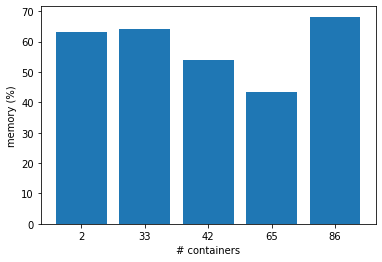

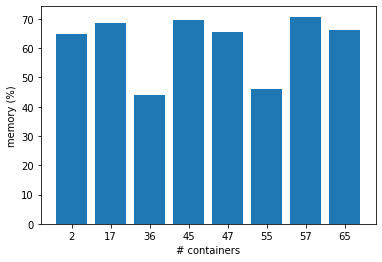

In [39]:
for j in range(NUMBER_SAVE_TESTS):
    my_dict = {}
    for run in all_run:
        for l in run[j]:
            if my_dict.get(int(l[2])) is None:
                my_dict[int(l[2])] = {'sum': l[1],
                                          'count': 1}
            else:
                my_dict[int(l[2])]['sum'] += l[1]
                my_dict[int(l[2])]['count'] += 1
    x = []
    y = []
    for i in sorted(my_dict.keys()):
        #if my_dict[i]['count'] == 3:
        x.append(i)
        y.append(my_dict[i]['sum']/my_dict[i]['count'])
    fig, ax = plt.subplots()

    ax.bar([i for i in range(len(y))], y)
    ax.set_xticks([i for i in range(len(y))])
    # ax.set_xticklabels(x, rotation=65)
    ax.set_xticklabels(x)
    ax.set_xlabel('# containers')
    ax.set_ylabel('memory (%)')
    plt.show()
    name = 'riccardo_memory_container' + str(j+1) +'.png'
    # plt.savefig(name)

# Network function container

In [40]:
NUMBER_SAVE_TESTS = 4
NUMBER_TESTS = 6

df_s01 = pd.read_csv("data/network/michela/sent01.csv")
print(df_s01)
df_s02 = pd.read_csv("data/network/michela/sent02.csv")
print(df_s02)
df_s03 = pd.read_csv("data/network/michela/sent03.csv")
print(df_s03)

df_r01 = pd.read_csv("data/network/michela/received01.csv")
print(df_r01)
df_r02 = pd.read_csv("data/network/michela/received02.csv")
print(df_r02)
df_r03 = pd.read_csv("data/network/michela/received03.csv")
print(df_r03)

df_c01 = pd.read_csv("data/network/michela/eliot_container01.csv")
print(df_c01)
df_c02 = pd.read_csv("data/network/michela/eliot_container02.csv")
print(df_c02)
df_c03 = pd.read_csv("data/network/michela/eliot_container03.csv")
print(df_c03)

test_times_file = open("data/network/michela/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time  eliot-bootstrap-server-6c9db94588-ncrlk  \
0     2020-08-29 15:56:28                                      0.0   
1     2020-08-29 15:56:30                                      0.0   
2     2020-08-29 15:56:32                                      0.0   
3     2020-08-29 15:56:34                                      0.0   
4     2020-08-29 15:56:36                                      0.0   
...                   ...                                      ...   
1906  2020-08-29 17:00:00                                      0.0   
1907  2020-08-29 17:00:02                                      0.0   
1908  2020-08-29 17:00:04                                      0.0   
1909  2020-08-29 17:00:06                                      0.0   
1910  2020-08-29 17:00:08                                      0.0   

      eliot-server-5ff5d96c48-vc4vj  eliot-weather-584cf4464c-227pb  \
0                               0.0                             NaN   
1                

                     Time  eliot-bootstrap-server-6c9db94588-l86qg  \
0     2020-08-29 17:46:58                                      0.0   
1     2020-08-29 17:47:00                                      0.0   
2     2020-08-29 17:47:02                                      0.0   
3     2020-08-29 17:47:04                                      0.0   
4     2020-08-29 17:47:06                                      0.0   
...                   ...                                      ...   
1865  2020-08-29 18:49:08                                      0.0   
1866  2020-08-29 18:49:10                                      0.0   
1867  2020-08-29 18:49:12                                      0.0   
1868  2020-08-29 18:49:14                                      0.0   
1869  2020-08-29 18:49:16                                      0.0   

      eliot-server-5ff5d96c48-nx8zd  eliot-weather-584cf4464c-22mvr  \
0                               0.0                             NaN   
1                

                     Time  eliot-bootstrap-server-6c9db94588-5jj64  \
0     2020-08-29 19:21:14                                      0.0   
1     2020-08-29 19:21:16                                      0.0   
2     2020-08-29 19:21:18                                      0.0   
3     2020-08-29 19:21:20                                      0.0   
4     2020-08-29 19:21:22                                      0.0   
...                   ...                                      ...   
1840  2020-08-29 20:22:34                                      0.0   
1841  2020-08-29 20:22:36                                      0.0   
1842  2020-08-29 20:22:38                                      0.0   
1843  2020-08-29 20:22:40                                      0.0   
1844  2020-08-29 20:22:42                                      0.0   

      eliot-server-5ff5d96c48-gtkwm  eliot-weather-584cf4464c-22hbm  \
0                          0.000000                             NaN   
1                

                     Time  eliot-bootstrap-server-6c9db94588-ncrlk  \
0     2020-08-29 15:56:28                                        0   
1     2020-08-29 15:56:30                                        0   
2     2020-08-29 15:56:32                                        0   
3     2020-08-29 15:56:34                                        0   
4     2020-08-29 15:56:36                                        0   
...                   ...                                      ...   
1906  2020-08-29 17:00:00                                        0   
1907  2020-08-29 17:00:02                                        0   
1908  2020-08-29 17:00:04                                        0   
1909  2020-08-29 17:00:06                                        0   
1910  2020-08-29 17:00:08                                        0   

      eliot-server-5ff5d96c48-vc4vj  eliot-weather-584cf4464c-227pb  \
0                               0.0                             NaN   
1                

                     Time  eliot-bootstrap-server-6c9db94588-l86qg  \
0     2020-08-29 17:46:58                                        0   
1     2020-08-29 17:47:00                                        0   
2     2020-08-29 17:47:02                                        0   
3     2020-08-29 17:47:04                                        0   
4     2020-08-29 17:47:06                                        0   
...                   ...                                      ...   
1865  2020-08-29 18:49:08                                        0   
1866  2020-08-29 18:49:10                                        0   
1867  2020-08-29 18:49:12                                        0   
1868  2020-08-29 18:49:14                                        0   
1869  2020-08-29 18:49:16                                        0   

      eliot-server-5ff5d96c48-nx8zd  eliot-weather-584cf4464c-22mvr  \
0                               0.0                             NaN   
1                

                     Time  eliot-bootstrap-server-6c9db94588-5jj64  \
0     2020-08-29 19:21:14                                        0   
1     2020-08-29 19:21:16                                        0   
2     2020-08-29 19:21:18                                        0   
3     2020-08-29 19:21:20                                        0   
4     2020-08-29 19:21:22                                        0   
...                   ...                                      ...   
1840  2020-08-29 20:22:34                                        0   
1841  2020-08-29 20:22:36                                        0   
1842  2020-08-29 20:22:38                                        0   
1843  2020-08-29 20:22:40                                        0   
1844  2020-08-29 20:22:42                                        0   

      eliot-server-5ff5d96c48-gtkwm  eliot-weather-584cf4464c-22hbm  \
0                               0.0                             NaN   
1                

In [44]:
test_time = retrieve_start_and_end_time(test_times)

In [45]:
test_time

{'Start_01': ['2020-08-29 15:56:27',
  '2020-08-29 17:46:57',
  '2020-08-29 19:21:13'],
 'End_01': ['2020-08-29 16:08:30',
  '2020-08-29 17:57:23',
  '2020-08-29 19:30:20'],
 'Start_02': ['2020-08-29 16:09:36',
  '2020-08-29 17:58:28',
  '2020-08-29 19:31:35'],
 'End_02': ['2020-08-29 16:19:28',
  '2020-08-29 18:08:21',
  '2020-08-29 19:41:28'],
 'Start_03': ['2020-08-29 16:20:43',
  '2020-08-29 18:09:37',
  '2020-08-29 19:42:44'],
 'End_03': ['2020-08-29 16:29:09',
  '2020-08-29 18:18:03',
  '2020-08-29 19:51:11'],
 'Start_04': ['2020-08-29 16:30:15',
  '2020-08-29 18:19:09',
  '2020-08-29 19:52:27'],
 'End_04': ['2020-08-29 16:38:47',
  '2020-08-29 18:27:52',
  '2020-08-29 20:01:11'],
 'Start_05': ['2020-08-29 16:40:03',
  '2020-08-29 18:28:59',
  '2020-08-29 20:02:37'],
 'End_05': ['2020-08-29 16:48:59',
  '2020-08-29 18:37:57',
  '2020-08-29 20:11:35'],
 'Start_06': ['2020-08-29 16:50:14',
  '2020-08-29 18:39:22',
  '2020-08-29 20:12:50'],
 'End_06': ['2020-08-29 17:00:08',
  '2020

In [46]:
def get_network_cont(df_m, df_c, num_r):
    new_val = []
    for i, row in df_m.iterrows():
        time = row['Time']
        all_cont_sent = df_m.iloc[[i],1:].values[0]
        sent_traff = 0
        c_row = df_c.iloc[ i*2 , : ]
        cont = str(c_row['Value'])
        if cont != 'nan':
            for v in all_cont_sent:
                if str(v) != 'nan':
                    sent_traff += v
            new_val.append([time, sent_traff, float(cont)])
    save = []
    for index in range(len(new_val)):
        line = new_val[index]
        if index+1 < len(new_val):
            if line[2] != new_val[index+1][2]:
                save.append(line)
    all_tests = []
    for j in range(NUMBER_TESTS):
        single_test = []
        interval = pd.Interval(pd.Timestamp(test_time['Start_0'+str(j+1)][num_r]),pd.Timestamp(test_time['End_0'+str(j+1)][num_r]))
        for line in save:
            if pd.Timestamp(line[0]) in interval:
                single_test.append(line)
        all_tests.append(single_test)
    return all_tests

### Sent network traffic 

In [47]:
all_run = []
all_run.append(get_network_cont(df_s01, df_c01, 0))
all_run.append(get_network_cont(df_s02, df_c02, 1))
all_run.append(get_network_cont(df_s03, df_c03, 2))

In [48]:
all_run

[[[['2020-08-29 15:56:28', 0.0, 2.0],
   ['2020-08-29 15:56:30', 0.0, 47.0],
   ['2020-08-29 15:56:38', 0.0, 52.0],
   ['2020-08-29 15:56:40', 0.0, 100.0],
   ['2020-08-29 15:56:48', 375.6048875939353, 102.0],
   ['2020-08-29 15:56:50', 650.1573867034705, 149.0],
   ['2020-08-29 15:56:58', 1170.1165416587205, 152.0],
   ['2020-08-29 15:57:00', 1305.8548950454688, 197.0],
   ['2020-08-29 15:57:08', 1823.388007693038, 202.0],
   ['2020-08-29 15:57:10', 1971.4811615309966, 245.0],
   ['2020-08-29 15:57:18', 2150.3167677313877, 252.0],
   ['2020-08-29 15:57:20', 2112.0753074540144, 294.0],
   ['2020-08-29 15:57:28', 1964.61552042377, 302.0],
   ['2020-08-29 15:57:30', 2002.204761129522, 343.0],
   ['2020-08-29 15:57:38', 2026.2505831537005, 352.0],
   ['2020-08-29 15:57:40', 2034.3563697090751, 391.0]],
  [['2020-08-29 16:09:38', 476.3402012259061, 47.0],
   ['2020-08-29 16:09:56', 508.31278014614384, 52.0],
   ['2020-08-29 16:09:58', 704.2860770513364, 95.0],
   ['2020-08-29 16:10:16', 12

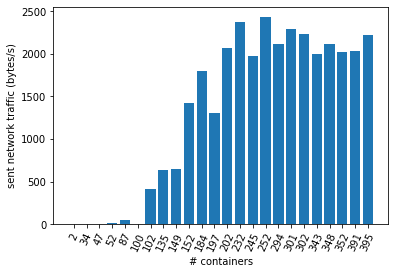

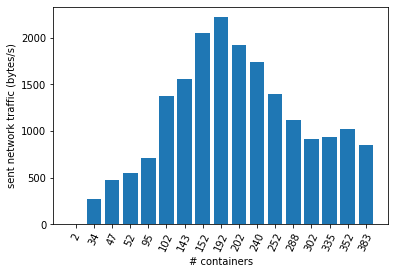

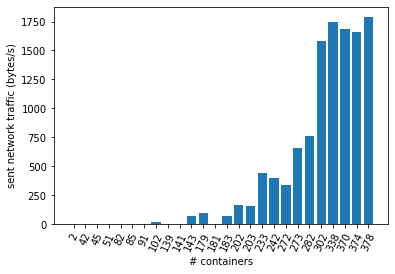

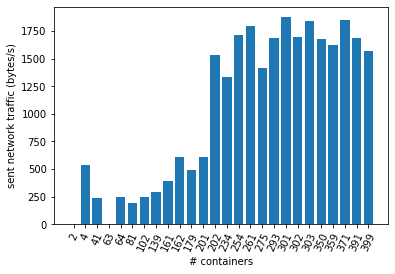

In [49]:
for j in range(NUMBER_SAVE_TESTS):
    my_dict = {}
    for run in all_run:
        for l in run[j]:
            if my_dict.get(int(l[2])) is None:
                my_dict[int(l[2])] = {'sum': l[1],
                                          'count': 1}
            else:
                my_dict[int(l[2])]['sum'] += l[1]
                my_dict[int(l[2])]['count'] += 1
    x = []
    y = []
    for i in sorted(my_dict.keys()):
        x.append(i)
        y.append(my_dict[i]['sum']/my_dict[i]['count'])
    fig, ax = plt.subplots()

    ax.bar([i for i in range(len(y))], y)
    ax.set_xticks([i for i in range(len(y))])
    ax.set_xticklabels(x, rotation=65)
    # ax.set_xticklabels(x)
    ax.set_xlabel('# containers')
    ax.set_ylabel('sent network traffic (bytes/s)')
    plt.show()
    name = 'michela_sent_traffic_container' + str(j+1) + '.png'
    # plt.savefig(name, bbox_inches="tight")

### Received netwrok traffic

In [50]:
all_run = []
all_run.append(get_network_cont(df_r01, df_c01, 0))
all_run.append(get_network_cont(df_r02, df_c02, 1))
all_run.append(get_network_cont(df_r03, df_c03, 2))

In [51]:
all_run

[[[['2020-08-29 15:56:28', 0.0, 2.0],
   ['2020-08-29 15:56:30', 0.0, 47.0],
   ['2020-08-29 15:56:38', 0.0, 52.0],
   ['2020-08-29 15:56:40', 0.0, 100.0],
   ['2020-08-29 15:56:48', 255.1379724105085, 102.0],
   ['2020-08-29 15:56:50', 297.21958068793685, 149.0],
   ['2020-08-29 15:56:58', 484.82445822364434, 152.0],
   ['2020-08-29 15:57:00', 509.79152501944316, 197.0],
   ['2020-08-29 15:57:08', 708.7621416277015, 202.0],
   ['2020-08-29 15:57:10', 750.1128610730233, 245.0],
   ['2020-08-29 15:57:18', 869.7583172134385, 252.0],
   ['2020-08-29 15:57:20', 895.2806842858873, 294.0],
   ['2020-08-29 15:57:28', 897.7598734561815, 302.0],
   ['2020-08-29 15:57:30', 863.4947676247708, 343.0],
   ['2020-08-29 15:57:38', 787.9491654760661, 352.0],
   ['2020-08-29 15:57:40', 912.79074582898, 391.0]],
  [['2020-08-29 16:09:38', 546.7032952972733, 47.0],
   ['2020-08-29 16:09:56', 493.6768772965303, 52.0],
   ['2020-08-29 16:09:58', 577.7682586529432, 95.0],
   ['2020-08-29 16:10:16', 961.4775

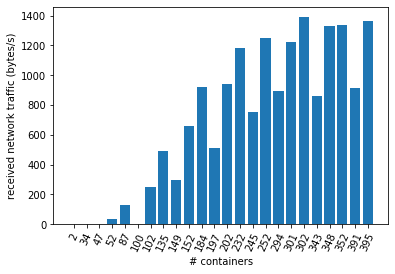

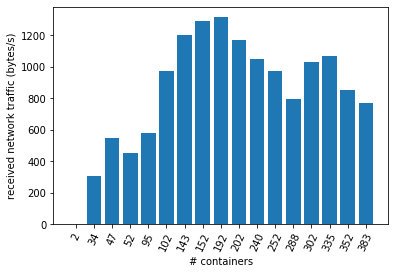

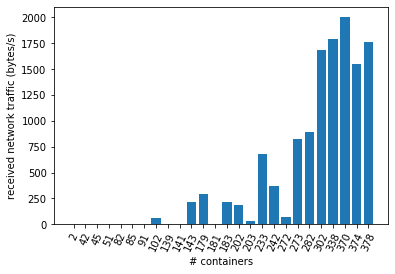

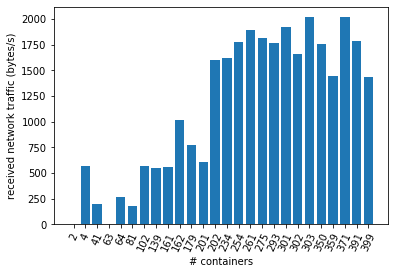

In [52]:
for j in range(NUMBER_SAVE_TESTS):
    my_dict = {}
    for run in all_run:
        for l in run[j]:
            if my_dict.get(int(l[2])) is None:
                my_dict[int(l[2])] = {'sum': l[1],
                                          'count': 1}
            else:
                my_dict[int(l[2])]['sum'] += l[1]
                my_dict[int(l[2])]['count'] += 1
    x = []
    y = []
    for i in sorted(my_dict.keys()):
        #if my_dict[i]['count'] == 3:
        x.append(i)
        y.append(my_dict[i]['sum']/my_dict[i]['count'])
    fig, ax = plt.subplots()

    ax.bar([i for i in range(len(y))], y)
    ax.set_xticks([i for i in range(len(y))])
    ax.set_xticklabels(x, rotation=65)
    # ax.set_xticklabels(x)
    ax.set_xlabel('# containers')
    ax.set_ylabel('received network traffic (bytes/s)')
    plt.show()
    name = 'michela_received_traffic_container' + str(j+1) + '.png'
    # plt.savefig(name, bbox_inches="tight")

# Throughput of a single test

In [20]:
df_t01 = pd.read_csv("data/throughput/throughput01.csv")
print(df_t01)
df_t02 = pd.read_csv("data/throughput/throughput02.csv")
print(df_t02)
df_t03 = pd.read_csv("data/throughput/throughput03.csv")
print(df_t03)


test_times_file = open("data/throughput/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time       Value
0     2020-08-29 15:56:17         NaN
1     2020-08-29 15:56:18         NaN
2     2020-08-29 15:56:19         NaN
3     2020-08-29 15:56:20         NaN
4     2020-08-29 15:56:21         NaN
...                   ...         ...
3827  2020-08-29 17:00:04  228.545728
3828  2020-08-29 17:00:05  231.235354
3829  2020-08-29 17:00:06  234.238356
3830  2020-08-29 17:00:07  234.623293
3831  2020-08-29 17:00:08  237.620446

[3832 rows x 2 columns]
                     Time       Value
0     2020-08-29 17:46:47         NaN
1     2020-08-29 17:46:48         NaN
2     2020-08-29 17:46:49         NaN
3     2020-08-29 17:46:50         NaN
4     2020-08-29 17:46:51         NaN
...                   ...         ...
3745  2020-08-29 18:49:12  217.990657
3746  2020-08-29 18:49:13  220.520016
3747  2020-08-29 18:49:14  218.287233
3748  2020-08-29 18:49:15  218.662984
3749  2020-08-29 18:49:16  222.603879

[3750 rows x 2 columns]
                     Time       Value


In [21]:
test_time = retrieve_start_and_end_time(test_times)
dict_test_values = retrieve_test_values(df_t01, df_t02, df_t03, test_time)

In [22]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration(values, times)

In [23]:
for index_test in range(TEST_NUMBER):
    length = int(dict_test_values["Test_" + str(index_test + 1) + "_time"])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"] = compute_mean_remove_outliers(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

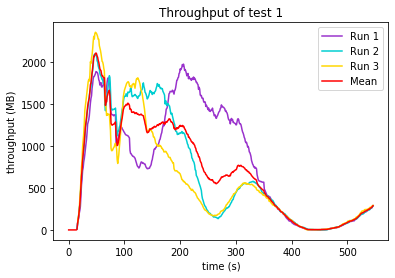

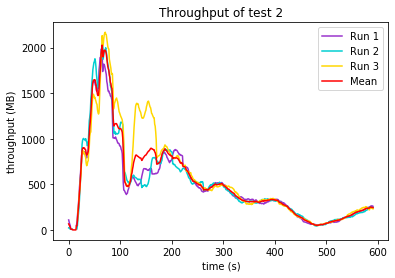

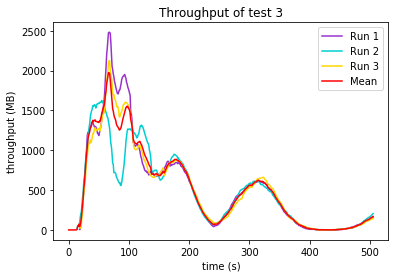

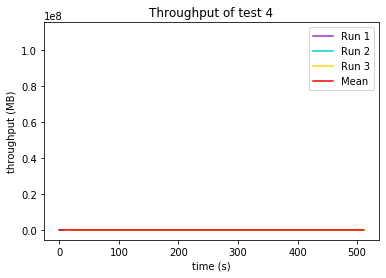

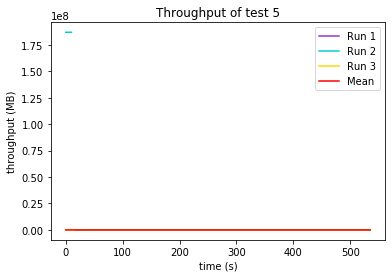

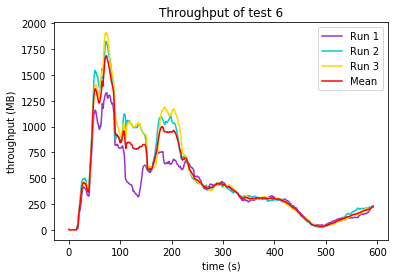

In [24]:
for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = range(int(dict_test_values["Test_" + str(index_test + 1) + "_time"]))
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    ax.set_title('Throughput of test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('throughput (MB)')
    leg = ax.legend();
    plt.show()

# Throughput of all tests

In [25]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"])

dict_test["times"], dict_test["values"] = fix_duration(dict_test["values"], dict_test["times"])

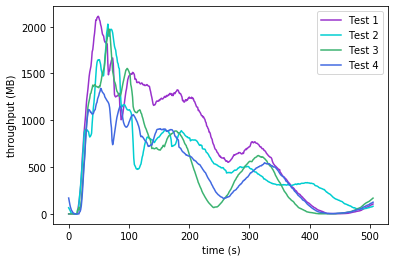

In [26]:
fig, ax = plt.subplots()
        
for index in range(TEST_NUMBER - 2):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Throughput of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('throughput (MB)')
plt.savefig("throughput_ELIoT_tests.png")

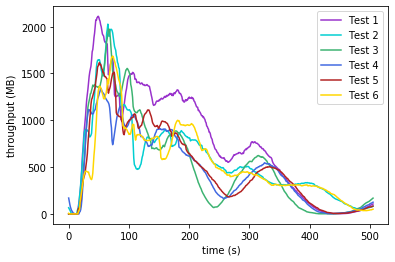

In [27]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = range(int(dict_test["times"]))
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('Throughput of all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('throughput (MB)')
plt.savefig("throughput_all_tests.png")

# CPU of a single test

In [28]:
df_c01 = pd.read_csv("data/cpu-eliot/cpu_eliot01.csv")
print(df_c01)
df_c02 = pd.read_csv("data/cpu-eliot/cpu_eliot02.csv")
print(df_c02)
df_c03 = pd.read_csv("data/cpu-eliot/cpu_eliot03.csv")
print(df_c03)


test_times_file = open("data/cpu-eliot/test_times.log", "r")
test_times = test_times_file.readlines()
print(test_times)

                     Time  nur container
0     2020-08-29 15:56:16       0.001530
1     2020-08-29 15:56:18       0.001460
2     2020-08-29 15:56:20       0.001721
3     2020-08-29 15:56:22       0.001371
4     2020-08-29 15:56:24       0.001391
...                   ...            ...
1912  2020-08-29 17:00:00       0.006874
1913  2020-08-29 17:00:02       0.006678
1914  2020-08-29 17:00:04       0.007258
1915  2020-08-29 17:00:06       0.006659
1916  2020-08-29 17:00:08       0.007476

[1917 rows x 2 columns]
                     Time  nur container
0     2020-08-29 17:46:46       0.001263
1     2020-08-29 17:46:48       0.001383
2     2020-08-29 17:46:50       0.001339
3     2020-08-29 17:46:52       0.001136
4     2020-08-29 17:46:54       0.000935
...                   ...            ...
1871  2020-08-29 18:49:08       0.006305
1872  2020-08-29 18:49:10       0.006635
1873  2020-08-29 18:49:12       0.006514
1874  2020-08-29 18:49:14       0.006738
1875  2020-08-29 18:49:16       

In [29]:
test_time = retrieve_start_and_end_time(test_times)

In [30]:
df = 0
dict_test_values = {}

for i in range(TEST_NUMBER):
    dict_test_values["Test_" + str(i + 1) + "_values"] = []
    dict_test_values["Test_" + str(i + 1) + "_time"] = []
    for j in range(RUN_NUMBER):
        if j == 0:
            df = df_c01
        elif j == 1:
            df = df_c02
        else:
            df = df_c03

        test_interval = pd.Interval(pd.Timestamp(test_time["Start_0" + str(i + 1)][j]), pd.Timestamp(test_time["End_0" + str(i + 1)][j]), closed="left")
        test_values = []
        test_seconds = []

        for time in df["Time"]:
            index = df[df['Time']==time].index.values.astype(int)[0]
            time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')
            if time in test_interval:
                test_values.append(df["nur container"][index])
                end_datetime = pd.to_datetime(test_time["End_0" + str(i + 1)][j], format='%Y-%m-%d %H:%M:%S')
                delta_time = end_datetime - time
                seconds = delta_time.total_seconds()
                test_seconds.append(seconds)

        total_seconds = retrieve_total_seconds(test_time["Start_0" + str(i + 1)][j], test_time["End_0" + str(i + 1)][j])

        seconds = []
        for second in test_seconds:
            sec = total_seconds - second
            seconds.append(sec)
                                   
        dict_test_values["Test_" + str(i + 1) + "_values"].append(test_values)
        dict_test_values["Test_" + str(i + 1) + "_time"].append(seconds)

In [31]:
for index_test in range(TEST_NUMBER):
    times = dict_test_values["Test_" + str(index_test + 1) + "_time"]
    values = dict_test_values["Test_" + str(index_test + 1) + "_values"]
    dict_test_values["Test_" + str(index_test + 1) + "_time"], dict_test_values["Test_" + str(index_test + 1) + "_values"] = fix_duration_with_time(values, times)

In [32]:
for index in range(TEST_NUMBER):
    new_values = []
    for run in range(RUN_NUMBER):
        run_values =  dict_test_values['Test_' + str(index + 1) +'_values'][run]
        new_values.append(from_s_to_ms(run_values))
    dict_test_values['Test_' + str(index + 1) +'_values'] = new_values  

In [33]:
for index_test in range(TEST_NUMBER):
    length = len(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])
    dict_test_values["Test_" + str(index_test + 1) + "_mean"]= compute_mean(dict_test_values["Test_" + str(index_test + 1) + "_values"], length)

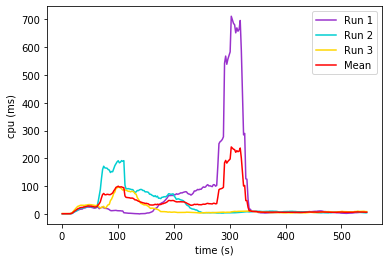

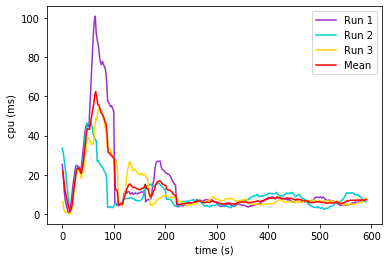

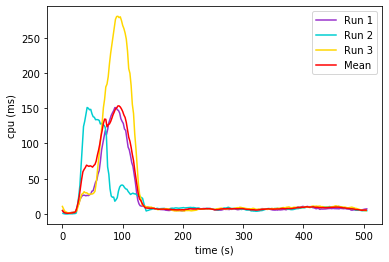

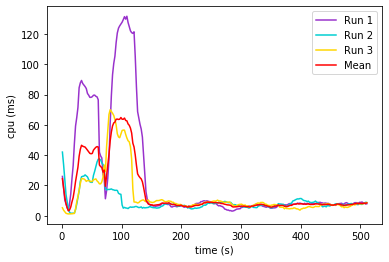

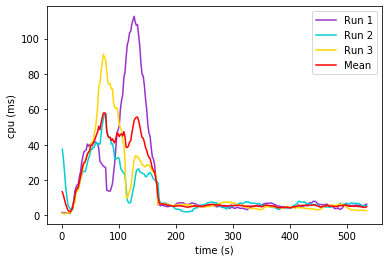

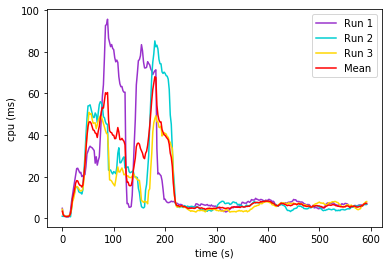

In [39]:
for index_test in range(TEST_NUMBER):
    fig, ax = plt.subplots()
    for index in range(RUN_NUMBER):
        x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
        y = dict_test_values["Test_" + str(index_test + 1) + "_values"][index]
        
        line_color = "gold"
        if(index == 0):
            line_color = "darkorchid"
        elif(index == 1):
            line_color = "darkturquoise"
        
        ax.plot(x, y, '-', label='Run ' + str(index + 1), color=line_color)
    x = dict_test_values["Test_" + str(index_test + 1) + "_time"][index]
    y = dict_test_values["Test_" + str(index_test + 1) + "_mean"]
    ax.plot(x, y, '-', label='Mean', color="red")
    #ax.set_title('CPU of test ' + str(index_test + 1))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('cpu (ms)')
    leg = ax.legend();
    plt.savefig("CPU_test0" + str(index_test + 1) + ".png")

# CPU of all tests

In [35]:
dict_test = {}
dict_test["values"] = []
dict_test["times"] = []
for index_test in range(TEST_NUMBER):
    dict_test["values"].append(dict_test_values["Test_" + str(index_test + 1) + "_mean"])
    dict_test["times"].append(dict_test_values["Test_" + str(index_test + 1) + "_time"][0])

dict_test["times"], dict_test["values"] = fix_duration_with_time(dict_test["values"], dict_test["times"])

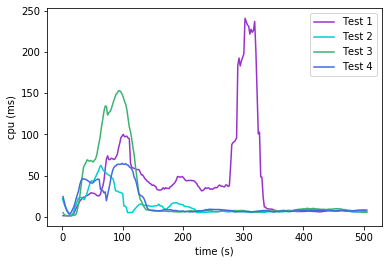

In [37]:
fig, ax = plt.subplots()
        
for index in range(TEST_NUMBER - 2):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('CPU of ELIoT tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('cpu (ms)')
plt.savefig("CPU_ELIoT_tests.png")

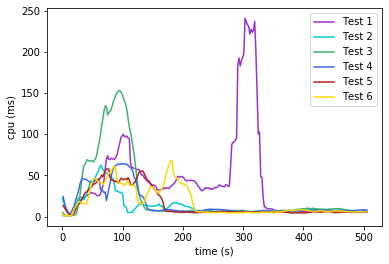

In [38]:
fig, ax = plt.subplots()
for index in range(TEST_NUMBER):
    x = dict_test["times"][index]
    y = dict_test["values"][index]
        
    line_color = "gold"
    if(index == 0):
        line_color = "darkorchid"
    elif(index == 1):
        line_color = "darkturquoise"
    elif(index == 2):
        line_color = "mediumseagreen"
    elif(index == 3):
        line_color = "royalblue"
    elif(index == 4):
        line_color = "firebrick"

    ax.plot(x, y, '-', label='Test ' + str(index + 1), color=line_color)
    leg = ax.legend();
#ax.set_title('CPU of all tests')
ax.set_xlabel('time (s)')
ax.set_ylabel('cpu (ms)')
plt.savefig("cpu_all_tests.png")